# App code for the search-and-rescue model

This notebook explores Python code for more than just testing our search-and-rescue Visual Recognition model.  This notebook prototypes code for identifying an object in a video frame, creating an image with just that object, and sending the image of the object to the Visual Recognition model.  Prototyping code here can make creating a web app later easier.

- Step 1: Install and import required libraries
- Step 2: Download sample frames from drone video footage
- Step 3: Detect the object in the frame
- Step 4: Create an image focussed on just the object
- Step 5: Classify the image of the object


## Step 1: Install and import required libraries

- [wget](https://pypi.org/project/wget/) for downloading sample video files to the notebook working directory
- [opencv-python](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_setup/py_intro/py_intro.html) for image processing
- watson_developer_cloud for working with [Watson Visual Recognition API](https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/python.html?python) and [Watson Text to Speech API](https://www.ibm.com/watson/developercloud/text-to-speech/api/v1/python.html?python)

In [1]:
!pip install --upgrade wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
!pip install --upgrade opencv-python

    100% |████████████████████████████████| 25.4MB 36kB/s  eta 0:00:01
Requirement not upgraded as not directly required: numpy>=1.11.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from opencv-python)


In [3]:
!pip install --upgrade watson-developer-cloud

    100% |████████████████████████████████| 286kB 3.1MB/s eta 0:00:01
Requirement not upgraded as not directly required: requests<3.0,>=2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud)
Requirement not upgraded as not directly required: python_dateutil>=2.5.3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud)
    100% |████████████████████████████████| 204kB 4.4MB/s eta 0:00:01
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.0->watson-developer-cloud)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.0->watson-developer-cloud)
Requirement not upgraded as not directly required: urllib3<1.23,>=1.21.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.0->watson-developer-c

In [5]:
import wget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
import re
from watson_developer_cloud import VisualRecognitionV3
import json

## Step 2: Download sample frames
To work with sample frames, use wget to download the files directly from GitHub to the notebook working directory.

In [8]:
!rm -f *.jpg
!rm -f *.png

filename_1 = 'video1_frame.jpg'
filename_2 = 'video2_frame.jpg'

url_base = 'https://github.com/IBMDataScience/Watson-Studio-Examples/raw/master/Search-and-rescue/sar-web-app/static/'

url_1 = url_base + filename_1
url_2 = url_base + filename_2

wget.download( url_1 )
wget.download( url_2 )

!ls -l

total 4228
-rw-r----- 1 dsxuser dsxuser 2001844 Mar 19 03:12 video1_frame.jpg
-rw-r----- 1 dsxuser dsxuser 2326276 Mar 19 03:12 video2_frame.jpg


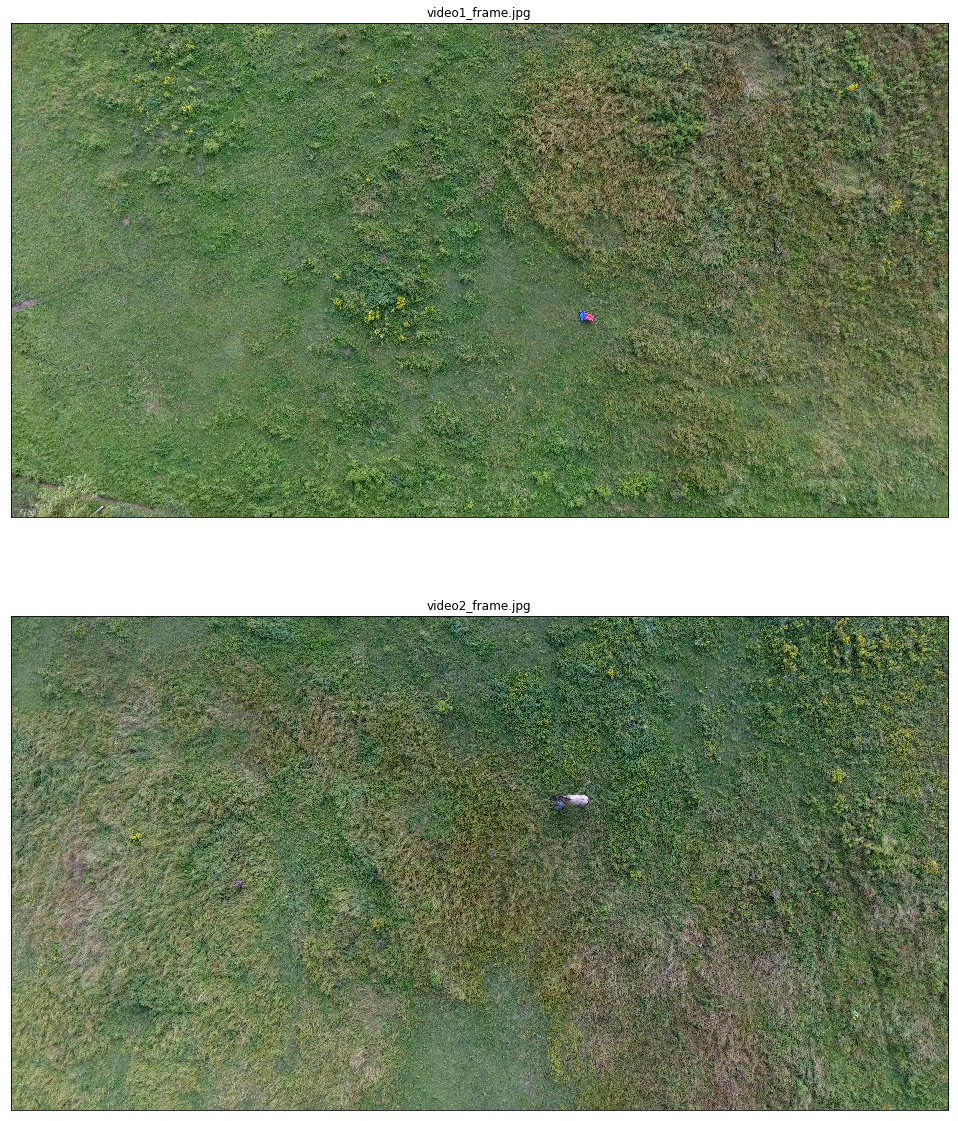

In [9]:
fig, axs = plt.subplots( 2, 1, figsize=( 18, 20 ) )
axs[0].imshow( mpimg.imread( filename_1 ) )
axs[0].set_title( filename_1 )
axs[1].imshow( mpimg.imread( filename_2 ) )
axs[1].set_title( filename_2 )
for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

## Step 3: Detect objects in the frame

Use a colour threshold to detect objects in the image that contrast with the green background:

1. Use [bitwise_not](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html) to produce a black-and-white image based on [colour thresholds](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html)
2. Identify the [contours](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_contours/py_table_of_contents_contours/py_table_of_contents_contours.html) between the white and the black

In [13]:
def applyColourThreshold( frame ):
    lower_green = ( 0, 0, 0 )
    upper_green = ( 90, 255, 255 )
    frame_hsv    = cv2.cvtColor( frame, cv2.COLOR_BGR2HSV )
    frame_mask   = cv2.bitwise_not( cv2.inRange( frame_hsv, lower_green, upper_green ) )
    return frame_mask

def findContours( frame_mask ):
    contours_arr, heirarchy = cv2.findContours( frame_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )
    return contours_arr

def showProgression( frame, frame_mask, contours_arr ):
    frame_w_contours = cv2.drawContours( frame.copy(), contours_arr, -1, ( 25, 255, 255 ), 2 )
    fig, axs = plt.subplots( 1, 3, figsize=( 25, 10 ) )
    axs[0].imshow( cv2.cvtColor( frame[500:1500,2000:3000], cv2.COLOR_BGR2RGB ), cmap='gray' )
    axs[0].set_title( 'Original frame' )
    axs[1].imshow( frame_mask[500:1500,2000:3000], cmap='gray')
    axs[1].set_title( 'Colour (green) threshold applied' )
    axs[2].imshow( cv2.cvtColor( frame_w_contours[500:1500,2000:3000], cv2.COLOR_BGR2RGB ), cmap='gray' )
    axs[2].set_title( 'Countours drawn onto original frame (in yellow)' )
    for img in axs:
        img.set_xticks([])
        img.set_yticks([])
        
def detectObjs( frame ):
    frame_mask   = applyColourThreshold( frame )
    contours_arr = findContours( frame_mask )
    showProgression( frame, frame_mask, contours_arr )
    return contours_arr

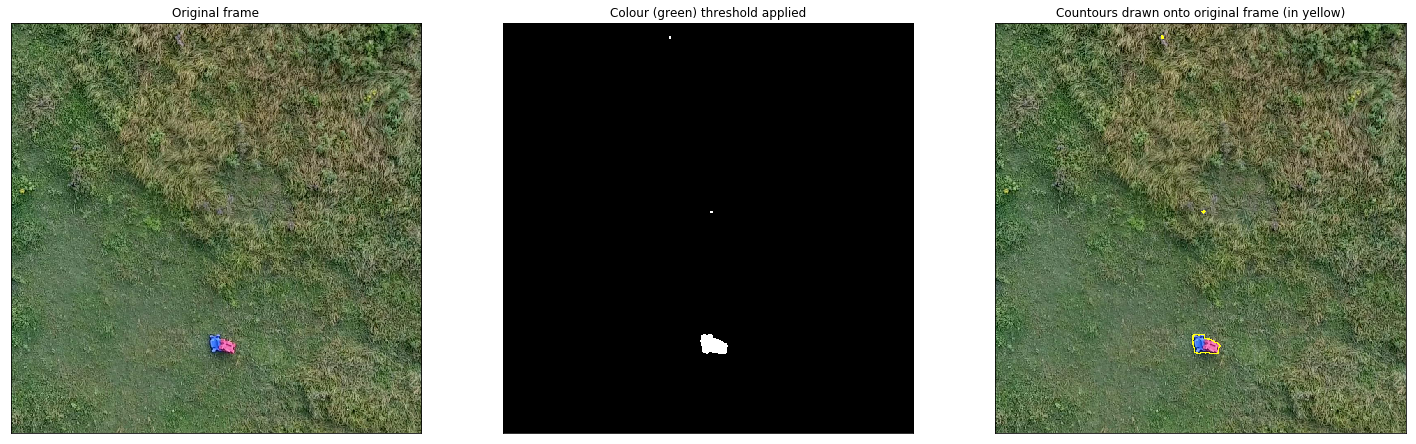

In [14]:
frame = cv2.imread( filename_1 )
contours_arr = detectObjs( frame )

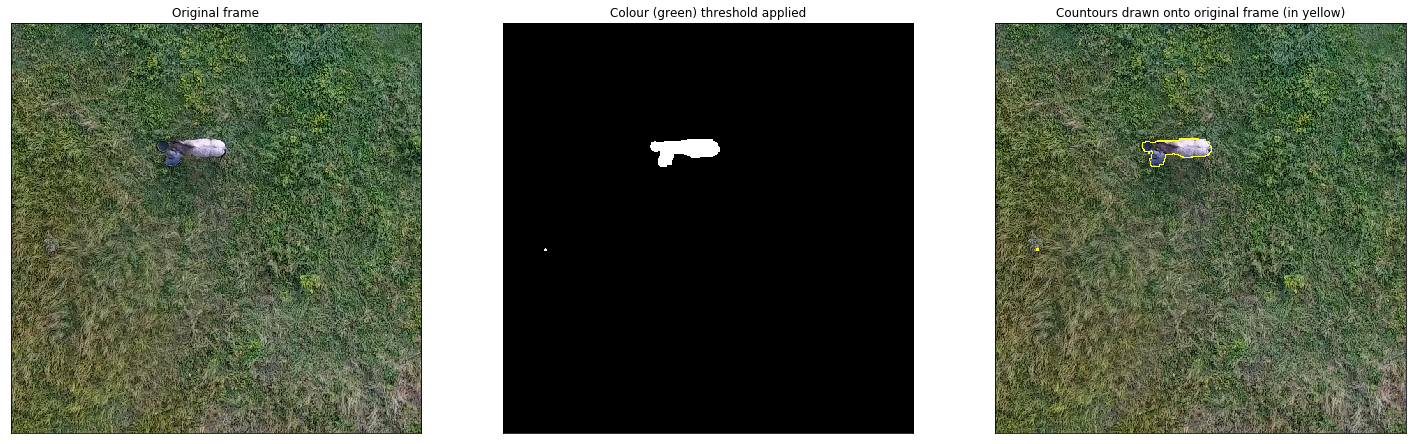

In [15]:
frame = cv2.imread( filename_2 )
contours_arr = detectObjs( frame )

## Step 4: Focus in on the object

Using the contours, we can create a ["bounding box"](https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html) around the object in the frame.

In [16]:
# There are often tiny contours that are artifacts from an imperfect threshold result 
# (not surprising, given how simplistic the implementation is.)  So create a function 
# to select the contours that are big enough to see anything.
#
def get_object_bounding_boxes( contours_arr ):
    object_bounding_boxes = []
    for c in contours_arr:
        ( center, radius ) = cv2.minEnclosingCircle(c)
        if ( radius > 20 ):
            row_begin = int(round(center[1])) - int(round(radius)) - 5;
            row_end   = int(round(center[1])) + int(round(radius)) + 5;
            col_begin = int(round(center[0])) - int(round(radius)) - 5;
            col_end   = int(round(center[0])) + int(round(radius)) + 5;
            if( ( row_begin > 0 ) and ( col_begin > 0 ) ):
                object_bounding_boxes.append( ( row_begin, row_end, col_begin, col_end ) )
    return object_bounding_boxes

def bounding_box_size( box ):
    return ( box[1] - box[0] )

def getBiggestBox( boxes ):
    biggest_box = boxes[0]
    for i in range( 1, len( boxes ) ):
        if( bounding_box_size( boxes[i] ) > bounding_box_size( biggest_box ) ):
            biggest_box = boxes[i]
    return biggest_box
    
def showCloseup( frame, closeup ):
    fig, axs = plt.subplots( 1, 2, figsize=( 10, 4 ) )
    axs[0].imshow( cv2.cvtColor( frame, cv2.COLOR_BGR2RGB ), cmap='gray' )
    axs[0].set_title( 'Original frame' )
    axs[1].imshow( cv2.cvtColor( closeup, cv2.COLOR_BGR2RGB ), cmap='gray' )
    axs[1].set_title( 'Closeup' )

def getCloseup( frame ):
    frame_mask   = applyColourThreshold( frame )
    contours_arr = findContours( frame_mask )
    bounding_box = getBiggestBox( get_object_bounding_boxes( contours_arr ) )
    closeup      = frame[ bounding_box[0]:bounding_box[1], bounding_box[2]:bounding_box[3] ]
    showCloseup( frame, closeup )
    return closeup

def saveCloseup( filename ):
    frame = cv2.imread( filename )
    closeup = getCloseup( frame )
    new_filename = re.sub( '.jpg', '', filename ) + '_closeup.png'
    cv2.imwrite( new_filename, closeup )
    return new_filename

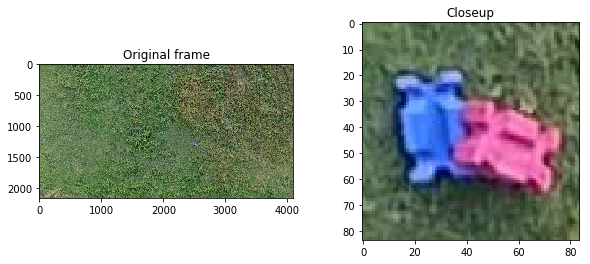

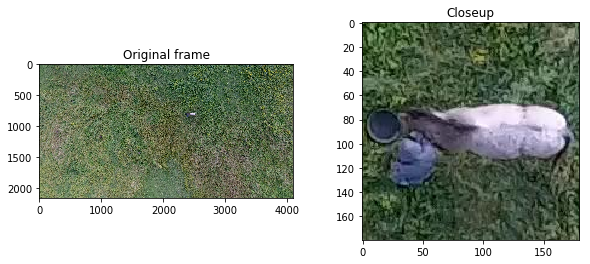

In [17]:
closeup_filename_1 = saveCloseup( filename_1 )
closeup_filename_2 = saveCloseup( filename_2 )

## Step 5: Classify the close-up image

Use the [Watson Visual Recognition Python client API](https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/python.html?python) to send closup image to our trained model for classification.

### Prerequisite
Look up the apikey for the Visual Recognition service instance and the ID of the custom model:
1. From the **Services** menu in Watson Studio (top of the screen) right-click "Watson Services" and then open the link in a new browser tab
2. In the new Watson services tab, click the service instance in the Visual Recognition list
3. In the **Overview** tab, scroll down to the list of your custom models and then click "Copy model ID"
4. In the **Credentials** tab, expand credentials and then copy the apikey

In [18]:
model_id = '' # <-- PASTE YOUR MODEL ID HERE
apikey   = '' # <-- PASTE YOUR APIKEY HERE

In [19]:
visual_recognition = VisualRecognitionV3( version='2018-03-19', iam_apikey=apikey )

def getKey( item ):
    return item["score"]

def getTopClass( results ):
    results_classes = results["images"][0]["classifiers"][0]["classes"]
    sorted_results_classes = sorted( results_classes, key=getKey, reverse=True )
    return sorted_results_classes[0]

def classifyObject( filename ):
    with open( filename, 'rb' ) as image_file:
        results = visual_recognition.classify( image_file, threshold='0', classifier_ids=model_id ).get_result()
        top_class = getTopClass( results )
        return { 'top_class' : top_class, 'results' : results }

{'score': 0.896, 'class': 'blocks'}


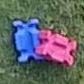

In [20]:
closeup_filename = closeup_filename_1
results = classifyObject( closeup_filename )
#print( json.dumps( results, indent=3 ) )
print( results["top_class"] )
Image.open( closeup_filename )

{'score': 0.839, 'class': 'horse'}


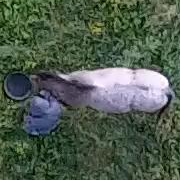

In [21]:
closeup_filename = closeup_filename_2
results = classifyObject( closeup_filename )
#print( json.dumps( results, indent=3 ) )
print( results["top_class"] )
Image.open( closeup_filename )

Copyright © 2018 IBM. This notebook and its source code are released under the terms of the MIT License.